In [2]:
import pandas as pd
import scipy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

In [3]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("talk")
    sns.set_style("whitegrid")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')


In [4]:
prepare_plot()

In [5]:
import numpy as np
import scipy as sc


def summarize(x, y):

    summary_statistics = np.empty(8)
    # Slope, intercept, R
    summary_statistics[0], summary_statistics[1], summary_statistics[
        2
    ], pval, stderr = sc.stats.linregress(x, y)
    # R**2
    summary_statistics[3] = summary_statistics[2] ** 2
    # RMSE
    summary_statistics[4] = np.sqrt(np.mean((y - x) ** 2))
    # MSE
    summary_statistics[5] = np.mean(y - x)
    # MUE
    summary_statistics[6] = np.mean(np.absolute(y - x))
    # Tau
    summary_statistics[7], prob = sc.stats.kendalltau(x, y)

    return summary_statistics


def bootstrap(
    x, x_sem, y, y_sem, cycles=1000, with_replacement=True, with_uncertainty=True
):
    summary_statistics = np.empty((cycles, 8))
    for cycle in range(cycles):
        new_x = np.empty_like(x)
        new_y = np.empty_like(y)
        for index in range(len(x)):
            if with_replacement:
                j = np.random.randint(len(x))
            else:
                j = index
            if with_uncertainty and x_sem is not None:
                new_x[index] = np.random.normal(x[j], x_sem[j])
            elif with_uncertainty and x_sem is None:
                new_x[index] = x[j]
            if with_uncertainty and y_sem is not None:
                new_y[index] = np.random.normal(y[j], y_sem[j])
            elif with_uncertainty and y_sem is None:
                new_y[index] = y[j]
        summary_statistics[cycle] = summarize(new_x, new_y)

    results = {
        "mean": {
            "slope": np.mean(summary_statistics[:, 0]),
            "intercept": np.mean(summary_statistics[:, 1]),
            "R": np.mean(summary_statistics[:, 2]),
            "R**2": np.mean(summary_statistics[:, 3]),
            "RMSE": np.mean(summary_statistics[:, 4]),
        },
        "sem": {
            "slope": np.std(summary_statistics[:, 0]),
            "intercept": np.std(summary_statistics[:, 1]),
            "R": np.std(summary_statistics[:, 2]),
            "R**2": np.std(summary_statistics[:, 3]),
            "RMSE": np.std(summary_statistics[:, 4]),
        },
    }
    return results


In [6]:
def thermodynamic_bootstrap(
    x, x_sem, y, y_sem, cycles=1000, with_replacement=True, with_uncertainty=True
):
    summary_statistics = np.empty((cycles))
    R = 1.987204118e-3 # kcal/mol-K
    temperature = 300  # K
    beta = 1.0 / (R * temperature)

    for cycle in range(cycles):
        new_x = np.empty_like(x)
        new_y = np.empty_like(y)

        if with_uncertainty and x_sem is not None:
            new_x = np.random.normal(x, x_sem)
        elif with_uncertainty and x_sem is None:
            new_x = x
        if with_uncertainty and y_sem is not None:
            new_y = np.random.normal(y, y_sem)
        elif with_uncertainty and y_sem is None:
            new_y = y
        summary_statistics[cycle] = -R * temperature * np.log(np.exp(-beta * new_x) + np.exp(-beta * new_y))
      
    results = {
        "mean": np.mean(summary_statistics),
        "sem": np.std(summary_statistics)
    }
    return results

In [ ]:
smirnoff_vs_bgbg = pd.read_csv("results.csv")

In [ ]:
smirnoff_vs_bgbg

In [ ]:
smirnoff

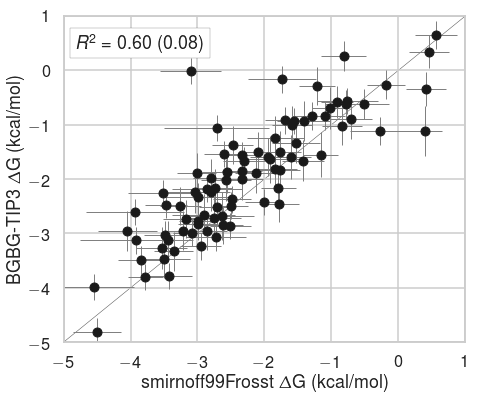

In [10]:
# r_squared = (
#     sc.stats.pearsonr(
#         smirnoff_vs_bgbg["smirnoff_fe"], smirnoff_vs_bgbg["bgbg_tip3p_fe"]
#     )[0]
#     ** 2
# )

statistics = bootstrap(smirnoff_vs_bgbg["smirnoff_fe"],
                       smirnoff_vs_bgbg["smirnoff_sem"],
                       smirnoff_vs_bgbg["bgbg_tip3p_fe"],
                       smirnoff_vs_bgbg["bgbg_tip3p_sem"],
                       cycles=1000)



fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    smirnoff_vs_bgbg["smirnoff_fe"],
    smirnoff_vs_bgbg["bgbg_tip3p_fe"],
    xerr=smirnoff_vs_bgbg["smirnoff_sem"],
    yerr=smirnoff_vs_bgbg["bgbg_tip3p_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-5, 1)
ax.set_xlim(-5, 1)
ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.2, alpha=1)
ax.annotate(
        f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
        xy=(0.03, 0.9),
        xycoords="axes fraction",
        size=18,
        bbox=bbox_props,
    )
# paper_plot(fig)


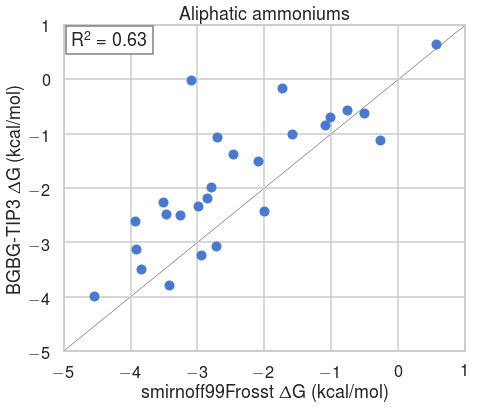

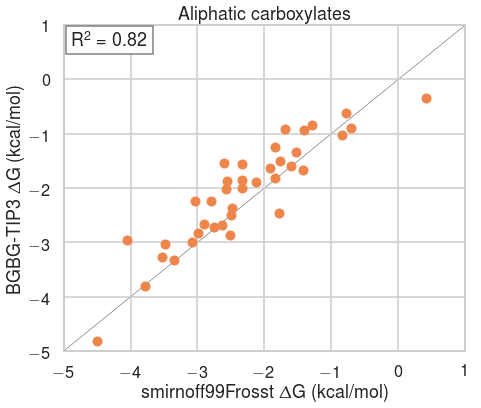

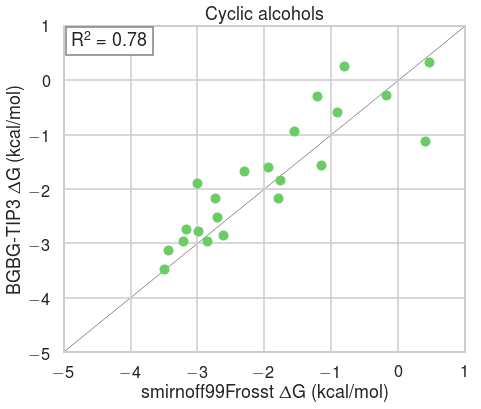

In [263]:
guest_types = smirnoff_vs_bgbg["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["guest_type"] == guest_type]
    r_squared = sc.stats.pearsonr(df["smirnoff_fe"], df["bgbg_tip3p_fe"])[0] ** 2
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["smirnoff_fe"],
        df["bgbg_tip3p_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
        label=f"R$^2$ = {r_squared:02f}",
    )

    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-5, 1)
    ax.set_xlim(-5, 1)
    ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", alpha=0.5)
    bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=1)
    ax.annotate(
        f"R$^2$ = {r_squared:0.2f}",
        xy=(0.02, 0.94),
        xycoords="axes fraction",
        size=18,
        bbox=bbox_props,
    )
    # paper_plot(fig)


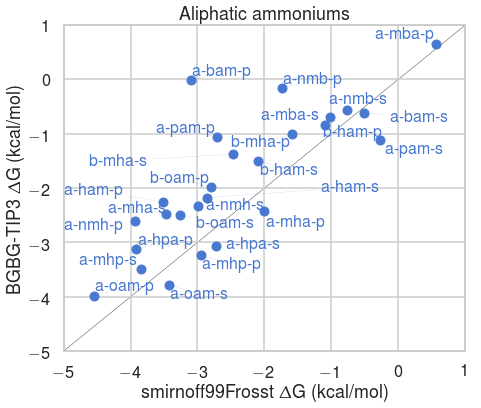

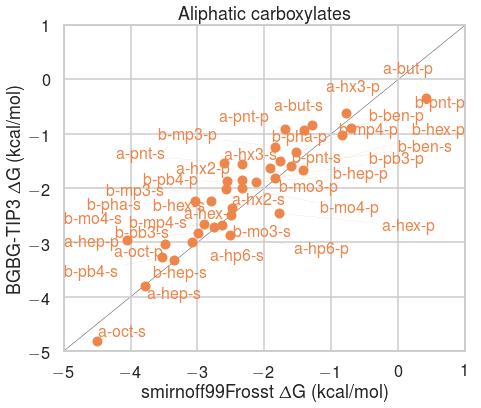

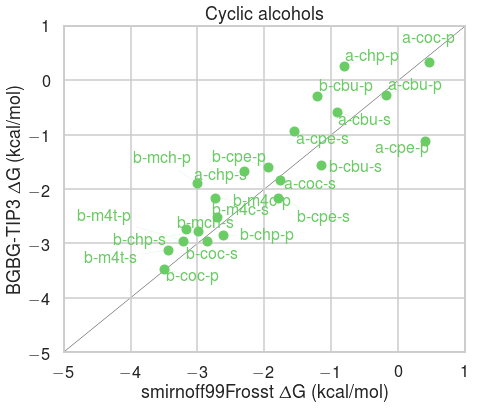

In [422]:
from adjustText import adjust_text

guest_types = smirnoff_vs_bgbg["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["guest_type"] == guest_type]
    r_squared = sc.stats.pearsonr(df["smirnoff_fe"], df["bgbg_tip3p_fe"])[0] ** 2

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["smirnoff_fe"],
        df["bgbg_tip3p_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
        label=f"R$^2$ = {r_squared:02f}",
    )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-5, 1)
    ax.set_xlim(-5, 1)
    ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_ylabel("BGBG-TIP3 $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", alpha=0.5)
    text = [
        plt.text(
            row["smirnoff_fe"],
            row["bgbg_tip3p_fe"],
            f"{row['system']}",
            size=16,
            color=colors[index],
        )
        for _, row in df.iterrows()
    ]
    adjust_text(
        text,
        #expand_points=(1.1, 1.3),
        arrowprops=dict(color=colors[index], arrowstyle="-", lw=0.1),
        #bbox=dict(pad=5),
        lim=500
    )

    # ax.annotate(f"R$^2$ = {r_squared:0.2f}", xy=(-4.8, 0.7), size=16, bbox=bbox_props)
    # paper_plot(fig)


In [13]:
smirnoff_vs_bgbg["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in smirnoff_vs_bgbg.iterrows()]

In [14]:
combined_smirnoff = pd.DataFrame()

for hg in smirnoff_vs_bgbg["short_system"].unique():
    df = smirnoff_vs_bgbg[smirnoff_vs_bgbg["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["smirnoff_fe"]
            primary_sem = row["smirnoff_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["smirnoff_fe"]
            secondary_sem = row["smirnoff_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_smirnoff = combined_smirnoff.append(pd.DataFrame({'system': hg,
                                 'smirnoff_fe' : results['mean'],
                                 'smirnoff_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: -3.1027 ± +0.45 S: -0.52 ± +0.37 → Boot: -3.11 ± +0.44
a-but P: +0.4090 ± +0.30 S: -1.30 ± +0.28 → Boot: -1.34 ± +0.25
a-cbu P: -0.1815 ± +0.28 S: -0.92 ± +0.24 → Boot: -1.09 ± +0.19
a-chp P: -0.8170 ± +0.34 S: -2.30 ± +0.31 → Boot: -2.36 ± +0.29
a-coc P: +0.4560 ± +0.30 S: -1.77 ± +0.30 → Boot: -1.78 ± +0.28
a-cpe P: +0.4015 ± +0.25 S: -1.55 ± +0.27 → Boot: -1.58 ± +0.26
a-ham P: -3.5112 ± +0.52 S: -2.86 ± +0.52 → Boot: -3.78 ± +0.42
a-hep P: -2.9987 ± +0.29 S: -3.78 ± +0.25 → Boot: -3.94 ± +0.21
a-hex P: -1.7827 ± +0.30 S: -2.50 ± +0.26 → Boot: -2.69 ± +0.20
a-hp6 P: -2.5122 ± +0.31 S: -3.08 ± +0.29 → Boot: -3.31 ± +0.22
a-hpa P: -3.9120 ± +0.85 S: -2.72 ± +0.45 → Boot: -4.10 ± +0.72
a-hx2 P: -2.3328 ± +0.30 S: -2.48 ± +0.29 → Boot: -2.86 ± +0.22
a-hx3 P: -0.7880 ± +0.30 S: -2.33 ± +0.28 → Boot: -2.38 ± +0.27
a-mba P: +0.5622 ± +0.31 S: -1.10 ± +0.31 → Boot: -1.14 ± +0.29
a-mha P: -2.0126 ± +0.28 S: -3.47 ± +0.31 → Boot: -3.52 ± +0.28
a-mhp P: -2.9519 ± +0.31 S: -3.84 ± +0.3

In [15]:
experimental_values = """a-nmb	-1.69	0.02
a-mba	-1.76	0.02
a-pam	-2.72	0.00
a-ham	-3.53	0.00
a-nmh	-3.52	0.01
a-mha	-3.60	0.00
a-hpa	-4.14	0.00
a-mhp	-4.17	0.00
a-oam	-4.61	0.01
b-ham	-2.49	0.08
b-mha	-2.56	0.07
b-oam	-3.59	0.12
a-cbu	-2.02	0.02
a-cpe	-2.13	0.02
a-chp	-2.51	0.06
a-coc	-3.23	1.14
b-cbu	-1.55	0.17
b-cpe	-3.05	0.01
b-mch	-4.18	0.01
b-m4c	-4.32	0.01
b-m4t	-4.54	0.01
b-chp	-4.56	0.01
b-coc	-4.97	0.04
a-but	-1.51	0.04
a-pnt	-2.60	0.01
a-hex	-3.38	0.01
a-hx2	-3.34	0.01
a-hx3	-3.01	0.01
a-hep	-3.99	0.01
a-hp6	-3.60	0.00
a-oct	-4.62	0.02
b-pnt	-1.27	0.32
b-hex	-2.28	0.03
b-hep	-3.39	0.18
b-ben	-1.64	0.02
b-pha	-1.70	0.05
b-mp3	-1.46	0.04
b-mp4	-2.19	0.01
b-mo3	-2.16	0.01
b-mo4	-2.51	0.01
b-pb3	-3.52	0.01
b-pb4	-3.60	0.02"""

In [16]:
experimental_data = pd.DataFrame()
for row in experimental_values.split("\n"):
    experimental_data = experimental_data.append(pd.DataFrame({'system': row.split('\t')[0],
                                 'exp_fe' : float(row.split('\t')[1]),
                                 'exp_sem': float(row.split('\t')[2]),
                                 }, index=[0]), ignore_index=True)

In [17]:
all_data = pd.merge(combined_smirnoff, experimental_data, on="system")

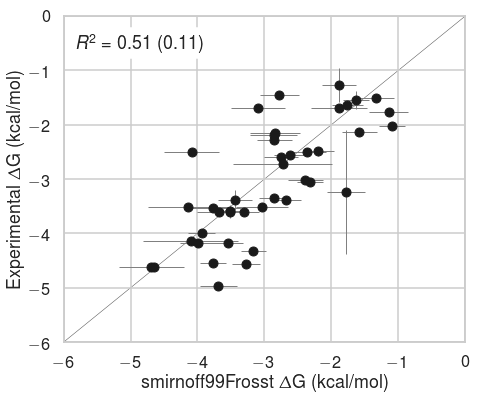

In [321]:
statistics = bootstrap(all_data["smirnoff_fe"],
                       all_data["smirnoff_sem"],
                       all_data["exp_fe"],
                       all_data["exp_sem"],
                       cycles=1000)

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    all_data["smirnoff_fe"],
    all_data["exp_fe"],
    xerr=all_data["smirnoff_sem"],
    yerr=all_data["exp_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
    label=f"R$^2$ = {r_squared:0.2f}",
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_ylabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="w", alpha=1)
ax.annotate(
    f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    xy=(0.03, 0.9),
    xycoords="axes fraction",
    size=18,
    bbox=bbox_props,
)
# paper_plot(fig)


NameError: name 'r_squared' is not defined

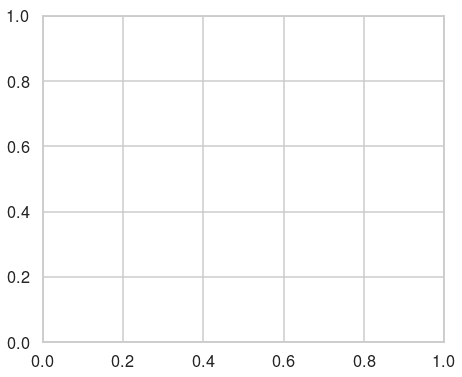

In [18]:
statistics = bootstrap(all_data["smirnoff_fe"],
                       all_data["smirnoff_sem"],
                       all_data["exp_fe"],
                       all_data["exp_sem"],
                       cycles=1000)

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    all_data["smirnoff_fe"],
    all_data["exp_fe"],
    xerr=all_data["smirnoff_sem"],
    yerr=all_data["exp_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
    label=f"R$^2$ = {r_squared:0.2f}",
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-6, 0)
ax.set_xlim(-6, 0)
ax.set_xlabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
ax.set_ylabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="w", alpha=1)
ax.annotate(
    f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    xy=(0.03, 0.9),
    xycoords="axes fraction",
    size=18,
    bbox=bbox_props,
)

text = [
    plt.text(
        row["smirnoff_fe"],
        row["exp_fe"],
        f"{row['system']}",
        size=16,
    )
    for _, row in all_data.iterrows()
]
adjust_text(
    text,
    #expand_points=(1.1, 1.3),
    arrowprops=dict(arrowstyle="-", lw=0.1),
    #bbox=dict(pad=5),
    lim=500
)



# paper_plot(fig)


In [19]:
statistics

{'mean': {'slope': 0.7692971593121346,
  'intercept': -0.78145593695756199,
  'R': 0.71070349397825494,
  'R**2': 0.51179252817530874,
  'RMSE': 0.77554554253969987},
 'sem': {'slope': 0.1102548328168258,
  'intercept': 0.32487164856154976,
  'R': 0.081811196192265234,
  'R**2': 0.11135797762182904,
  'RMSE': 0.10178178104084805}}

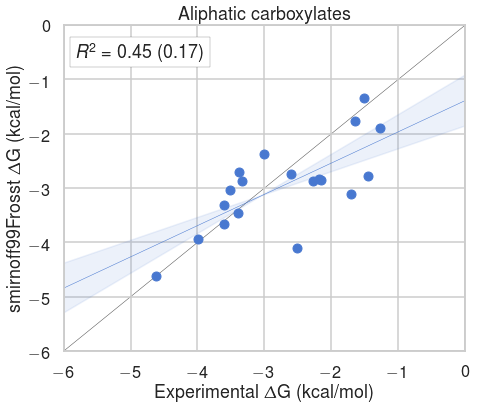

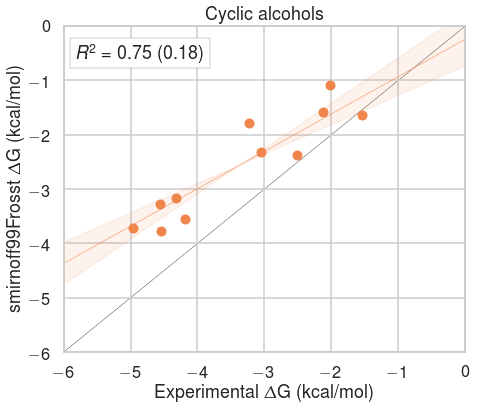

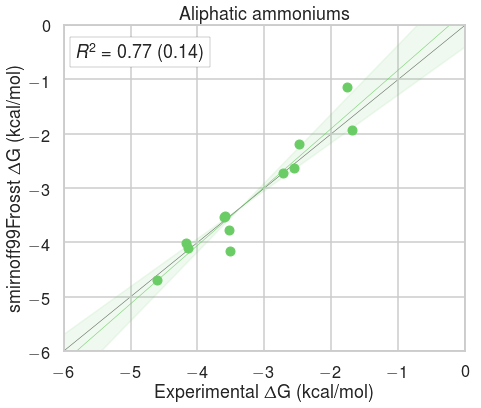

In [460]:
guest_types = all_data["guest_type"].unique()
colors = sns.color_palette("muted")

for index, guest_type in enumerate(guest_types):
    df = all_data[all_data["guest_type"] == guest_type]
    statistics = bootstrap(df["exp_fe"].values,
                       df["exp_sem"].values,
                           df["smirnoff_fe"].values,
                       df["smirnoff_sem"].values,
                       cycles=1000)
    
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    ax.errorbar(
        df["exp_fe"],
        df["smirnoff_fe"],
        # xerr=df["smirnoff_sem"],
        # yerr=df["bgbg_tip3p_sem"],
        fmt="o",
        c=colors[index],
        ecolor="0.5",
        elinewidth=1,
    )
    
    regression = statistics['mean']['slope'] * range(-50, 50) + statistics['mean']['intercept']
    ci_upper = (statistics['mean']['slope'] + statistics['sem']['slope']) * range(-50, 50) + (statistics['mean']['intercept'] + statistics['sem']['intercept'])
    ci_lower = (statistics['mean']['slope'] - statistics['sem']['slope']) * range(-50, 50) + (statistics['mean']['intercept'] - statistics['sem']['intercept'])
    ax.plot(range(-50, 50), regression, ls='-', lw=0.5, c=colors[index])
    ax.fill_between(range(-50, 50), ci_upper, ci_lower, color=colors[index], alpha=0.1 )
    
    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-6, 0)
    ax.set_xlim(-6, 0)
    ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
    guest_string = " ".join(guest_type.split("_"))
    guest_string = guest_string[0].upper() + guest_string[1:]
    ax.set_title(guest_string)
    bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.2, alpha=1)
    ax.annotate(
        f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
        xy=(0.03, 0.9),
        xycoords="axes fraction",
        size=18,
        bbox=bbox_props,
    )
    # paper_plot(fig)


In [11]:
overall_statistics = bootstrap(all_data["smirnoff_fe"],
                       all_data["smirnoff_sem"],
                       all_data["exp_fe"],
                       all_data["exp_sem"],
                       cycles=10000)

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}
all_data["color"] = [colors[i] for i in all_data["guest_type"]]

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
ax.annotate(
f"$R^2$ = {overall_statistics['mean']['R**2']:0.2f} ({overall_statistics['sem']['R**2']:0.2f})",
xy=(0.03, 0.94),
xycoords="axes fraction",
color="k",
size=14,
bbox=bbox_props,
)


for index, guest_type in enumerate(guest_types):
    df = all_data[all_data["guest_type"] == guest_type]
    statistics = bootstrap(
                       df["exp_fe"].values,
                       df["exp_sem"].values,
                       df["smirnoff_fe"].values,
                       df["smirnoff_sem"].values,
                       cycles=10000)
    
    ax.errorbar(
        df["exp_fe"],
        df["smirnoff_fe"],
        xerr=df["exp_sem"],
        yerr=df["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        ecolor="0.5",
        elinewidth=1,
        label=f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    )
    bbox_props = dict(boxstyle="square", fc="w",  ec="w", alpha=1)
    ax.annotate(
    f"$R^2$ = {statistics['mean']['R**2']:0.2f} ({statistics['sem']['R**2']:0.2f})",
    xy=(0.03, 0.88 - index*0.06),
    xycoords="axes fraction",
    color=colors[guest_type],
    size=14,
    bbox=bbox_props,
    )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-6, 0)
    ax.set_xlim(-6, 0)
    ax.set_ylabel("smirnoff99Frosst $\Delta$G (kcal/mol)", labelpad=5)
    ax.set_xlabel("Experimental $\Delta$G (kcal/mol)", labelpad=5)
#     guest_string = " ".join(guest_type.split("_"))
#     guest_string = guest_string[0].upper() + guest_string[1:]
#     ax.set_title(guest_string)
#    ax.legend()
#    handles, labels = ax.get_legend_handles_labels()
#    from matplotlib import container
#    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
#    ax.legend(handles, labels)


NameError: name 'all_data' is not defined

In [449]:
def count_simulation_time(window):
    # with open(os.path.join(window, "prod.000.in"), "r") as f:
    with open(os.path.join(window, "mdin"), "r") as f:
        read_data = f.read()
    dt = [float(i.split("=")[1][:-1]) for i in read_data.splitlines() if "dt" in i][0]
    nstlim = [
        int(i.split("=")[1][:-1]) for i in read_data.splitlines() if "nstlim" in i
    ][0]
    # trajectories = glob.glob(os.path.join(window, "prod") + "*.nc")
    trajectories = glob.glob(os.path.join(window, "traj") + "*")
    trajectories = [i for i in trajectories if "rst" not in i]
    number_trajectories = len(trajectories)

    simulation_time = dt * nstlim * number_trajectories

    return nstlim, number_trajectories, simulation_time


In [447]:
import glob
import os
windows = glob.glob("/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a*")
windows += glob.glob("/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/p*")
for window in windows:
    print(count_simulation_time(window))

(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 10, 10000.0)
(500000, 1

In [450]:
windows = glob.glob("/home/dslochower/niel-kirkwood/projects/cds/wat6/bgbg-tip3p/a-bam-p/a*")
windows += glob.glob("/home/dslochower/niel-kirkwood/projects/cds/wat6/bgbg-tip3p/a-bam-p/u*")
for window in windows:
    print(count_simulation_time(window))

(1250000, 200, 1000000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 5, 25000.0)
(1250000, 3, 15000.0)
(1250000, 2, 10000.0)
(1250000, 4, 20000.0)
(1250000, 3, 15000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 4, 20000.0)
(1250000, 6, 30000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 3, 15000.0)
(1250000, 3, 15000.0)
(1250000, 2, 10000.0)
(1250000, 6, 30000.0)
(1250000, 8, 40000.0)
(1250000, 2, 10000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 3, 15000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 2, 10000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000, 1, 5000.0)
(1250000

In [20]:
all_data

,system,smirnoff_fe,smirnoff_sem,guest_type,exp_fe,exp_sem
0,a-but,-1.344807,0.254883,aliphatic_carboxylates,-1.51,0.04
1,a-cbu,-1.091369,0.188274,cyclic_alcohols,-2.02,0.02
2,a-chp,-2.355022,0.291386,cyclic_alcohols,-2.51,0.06
3,a-coc,-1.776487,0.284903,cyclic_alcohols,-3.23,1.14
4,a-cpe,-1.580600,0.261536,cyclic_alcohols,-2.13,0.02
5,a-ham,-3.778417,0.419974,aliphatic_ammoniums,-3.53,0.00
6,a-hep,-3.942811,0.208729,aliphatic_carboxylates,-3.99,0.01
7,a-hex,-2.685180,0.202055,aliphatic_carboxylates,-3.38,0.01
8,a-hp6,-3.306547,0.224269,aliphatic_carboxylates,-3.60,0.00
9,a-hpa,-4.097773,0.718937,aliphatic_ammoniums,-4.14,0.00
